In [21]:
import kagglehub

# Download latest version
path = "kagglehub"

print("Path to dataset files:", path)

Path to dataset files: kagglehub


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

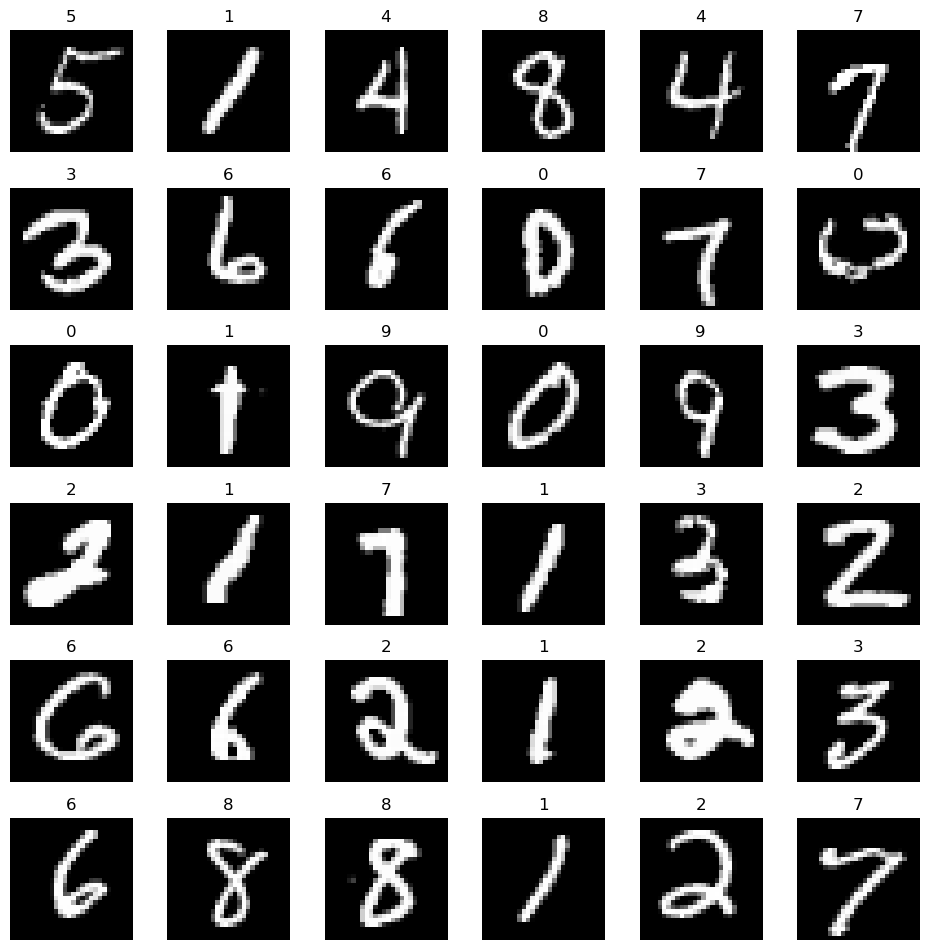

In [25]:
# ==== 1) Set up transforms ====
# If you only used ToTensor(), set mean,std to None
USE_NORMALIZE = False  # change to True if you added Normalize below
mean, std = (0.1307,), (0.3081,)

tx = [transforms.ToTensor()]
if USE_NORMALIZE:
    tx.append(transforms.Normalize(mean, std))
transform = transforms.Compose(tx)

# ==== 2) Dataset & loader ====
root = "kagglehub"  # your fixed folder: kagglehub/MNIST/raw/<four idx files>
train_ds = datasets.MNIST(root=root, train=True, transform=transform, download=False)
train_loader = DataLoader(train_ds, batch_size=36, shuffle=True)


test_ds = datasets.MNIST(root=root, train=False, transform=transform, download=False)
test_loader = DataLoader(test_ds, batch_size=36, shuffle=False)
# ==== 3) (Optional) inverse-normalize for display ====
def inv_norm(img):
    if not USE_NORMALIZE:
        return img
    m = torch.tensor(mean).view(-1, 1, 1)
    s = torch.tensor(std).view(-1, 1, 1)
    return img * s + m

# ==== 4) Show a grid of images ====
def show_batch(images, labels, nrow=6):
    # images: [B, C, H, W], labels: [B]
    B = images.size(0)
    C = images.size(1)
    H = images.size(2)
    W = images.size(3)
    assert C == 1, "This function is for MNIST (C=1)"
    assert H == 28 and W == 28, "Warning: image size is not 28x28"
    rows = (B + nrow - 1) // nrow
    plt.figure(figsize=(1.6*nrow, 1.6*rows))
    for i in range(B):
        plt.subplot(rows, nrow, i+1)
        img = inv_norm(images[i]).squeeze(0).cpu().numpy()  # MNIST: C=1
        plt.imshow(img, cmap="gray")
        plt.title(str(labels[i].item()))
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# ==== 5) Grab one batch and visualize ====
images, labels = next(iter(train_loader))
show_batch(images, labels, nrow=6)


In [42]:
class NumberClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1)  # in_ch=1 for MNIST
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=4, stride=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=10, kernel_size=3, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool8 = nn.MaxPool2d(kernel_size=8)

    def forward(self, x):
        # [B, 1, 28, 28]
        # Equation = floor((W - K + 2P) / S) + 1
        x = self.conv1(x) # [B, 8, 26, 26]
        x = torch.relu(x)
        x = self.pool2(x) # [B, 8, 13, 13]
        x = self.conv2(x) # [B, 16, 10, 10]
        x = torch.relu(x)
        x = self.conv3(x)  # [B, 10, 8, 8]
        x = self.pool8(x)  # [B, 10, 1, 1]
        x = x.view(x.size(0), -1)  # flatten, [B, 10*1*1=10]
        return x


In [43]:
import torch.optim as optim

epochs = 10

model = NumberClassifier()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

for epoch in range(epochs):
    accuracy = 0
    loss = 0
    for test_data, test_label in test_loader:
        test_prediction = model.forward(test_data)
        test_loss = loss_function(test_prediction, test_label)
        accuracy += (test_prediction.argmax(dim=1) == test_label).float().mean()
        loss += test_loss.item()
    accuracy /= len(test_loader)
    loss /= len(test_loader)
    print(f"Test Accuracy: {accuracy.item()*100:.2f}%, Loss: {loss:.4f}")
    for batch_idx, (data, label) in enumerate(train_loader):
        prediction = model.forward(data)
        loss = loss_function(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

print("Training finished.")

        

Test Accuracy: 11.54%, Loss: 2.3037
Epoch 1/10, Loss: 0.6260
Test Accuracy: 81.04%, Loss: 0.5586
Epoch 2/10, Loss: 0.6141
Test Accuracy: 85.44%, Loss: 0.4256
Epoch 3/10, Loss: 0.4268
Test Accuracy: 88.43%, Loss: 0.3415
Epoch 4/10, Loss: 0.3711
Test Accuracy: 89.39%, Loss: 0.3176
Epoch 5/10, Loss: 0.2586
Test Accuracy: 89.81%, Loss: 0.3002
Epoch 6/10, Loss: 0.4230
Test Accuracy: 90.92%, Loss: 0.2704
Epoch 7/10, Loss: 0.4044
Test Accuracy: 91.55%, Loss: 0.2480
Epoch 8/10, Loss: 0.1172
Test Accuracy: 91.74%, Loss: 0.2444
Epoch 9/10, Loss: 0.2198
Test Accuracy: 92.09%, Loss: 0.2341
Epoch 10/10, Loss: 0.0662
Training finished.


This is a good example of having CNN layers not just doing feature extraction, but also doing classification at the same time. Essentially, This manually restricts the points to be located at different 